In [1]:
import pandas as pd 
import torch 
import monai
import os
import pickle

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
import os
import torch
import monai
from concurrent.futures import ThreadPoolExecutor
from datasets import NoduleDataset
from datasets import getNoduleInfoList
from torch.utils.data import DataLoader

### IGNORE ###
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-15_22.17.11.log-fixedsize-no-resample-{fold_index}"
# path = f"/data/kaplinsp/models/log_DenseNet121_2025-04-18_00.50.31.log-fixedsize-no-resample-{fold_index}"
### IGNORE ###

# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-26_16.34.24.log-fixedsize-no-resample-sparse-log-{fold_index}" ### Using the very first dataset (4 folds)
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-27_13.21.46.log-fixedsize-no-resample-sparse-log-{fold_index}" ### Using the very first dataset (5 folds)
path = "/data/kaplinsp/models/log_DenseNet121_2025-04-28_13.35.53.log-fixedsize-tailored-epochs-{fold_index}"


def make_dataloader(path):
    with open(os.path.join(path, "val.pkl"), 'rb') as f:
        val_ids = pickle.load(f)
        nodules = getNoduleInfoList(['sclc'])
        nodules = [nod for nod in nodules if (nod.file_path, nod.center_lps) in val_ids]
        print(len(nodules))
        
    dataset = NoduleDataset(nodules, 
                isValSet_bool=True,
                dilate=20,
                resample=[64, 64, 64],
                box_size=[65, 65, 80],
                fixed_size=True
                )

    
    val_dl = DataLoader(
                dataset,
                batch_size=16,
                num_workers=4,
                pin_memory=True,
                drop_last=False,
                shuffle=True,
            )
    return val_dl

def load_model(fold_index):
    device = torch.device(fold_index % torch.cuda.device_count())

    model = monai.networks.nets.densenet121(
        dropout_prob=0.4, spatial_dims=3, in_channels=1, out_channels=2
    ).to(device)
    epochs = 3800 if fold_index in (0,1,2) else 1000
    # epochs = 3500
    model.load_state_dict(torch.load(os.path.join(path.format(fold_index=fold_index), f"best_loss_model_{epochs}.pth"))["model_state_dict"])
    model.eval()
    return model, device

def get_all_models_parallel(fold_indices):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(load_model, fold_indices))
    models, devices = zip(*results)
    return models, devices

networks, devices = get_all_models_parallel([0,1,2,3,4])


/tmp/ipykernel_4010955/887038079.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path.format(fold_index=fold_index), f"bes

2025-04-29 17:12:09,499 INFO     pid:2900062 datasets:211:__init__ <datasets.NoduleDataset object at 0x7f11f15d9d80>: 25 validation samples


25


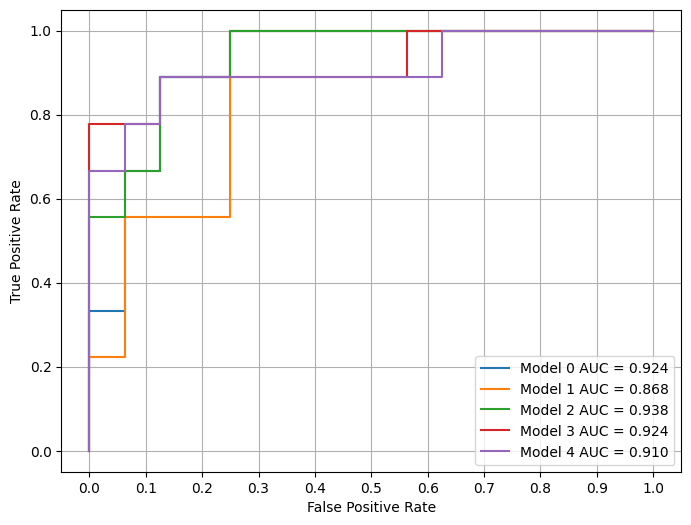

In [53]:
from matplotlib import pyplot as plt
from sklearn.metrics import auc, roc_curve
import numpy as np

plt.figure(figsize=(8, 6))  # Create one figure


val_dl = make_dataloader(path.format(fold_index=0))
for i, model in enumerate(networks):  # Limit to 5 models
    model.eval()
    
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        
        for inputs, labels in val_dl:
            inputs = inputs.to(i % torch.cuda.device_count())
            
            outputs = model(inputs)  # (batch_size, num_classes)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
    
    # Concatenate
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Compute ROC and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Model {i} AUC = {roc_auc:.3f}")

# After all models
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curves for 5 Models")
plt.xticks(np.arange(0,1.1,0.1))
plt.legend()
plt.grid(True)
plt.show()


In [3]:
"""ANALYSIS FOR ABSTRACT"""
from matplotlib import pyplot as plt
from sklearn.metrics import auc, precision_recall_curve, roc_curve
import numpy as np

# plt.figure(figsize=(8, 6))  # Create one figure


all_labels, all_probs = [], []

for network in networks:
    network.eval()
val_dl = make_dataloader(path.format(fold_index=0))
for inputs, labels in val_dl:
    batch_probs = []
    for i, model in enumerate(networks):
        inputs = inputs.to(i % torch.cuda.device_count(), non_blocking=True)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:,1].cpu()
        batch_probs.append(probs)
    
    avg_probs = torch.stack(batch_probs, dim=0).mean(dim=0)
    
    all_probs.append(avg_probs.cpu())
    all_labels.append(labels.cpu())
    
all_probs = torch.cat(all_probs).detach().numpy()
all_labels = torch.cat(all_labels).detach().numpy()



2025-04-30 21:07:55,685 INFO     pid:4010955 datasets:211:__init__ <datasets.NoduleDataset object at 0x7f36557a6ce0>: 25 validation samples


25


In [ ]:
# with open("abstract_metrics.pkl", "wb") as f:
#     pickle.dump({"probs": all_probs, "labels": all_labels},f )

In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import numpy as np
from sklearn.metrics import auc, precision_recall_curve, roc_curve

# Ensure models are in eval mode
for net in networks:
    net.eval()

all_labels, all_probs = [], []
val_dl = make_dataloader(path.format(fold_index=0))

def run_model_on_gpu(model, inputs, device_id):
    device = torch.device(f'cuda:{device_id}')
    inputs.pin_memory()
    input_gpu = inputs.to(device, non_blocking=True)
    with torch.no_grad():
        output = model(input_gpu)
        probs = torch.softmax(output, dim=1)[:, 1].cpu()
    print(probs)
    return probs

for inputs, labels in val_dl:
    futures = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        for i, model in enumerate(networks):
            futures.append(executor.submit(run_model_on_gpu, model, inputs, i % 4))

        # Collect results
        batch_probs = [future.result() for future in futures]

    avg_probs = torch.stack(batch_probs, dim=0).mean(dim=0)

    all_probs.append(avg_probs)
    all_labels.append(labels.cpu())
# Convert to NumPy
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()


2025-04-30 21:07:57,988 INFO     pid:4010955 datasets:211:__init__ <datasets.NoduleDataset object at 0x7f36a1720bb0>: 25 validation samples


25


metatensor([2.1217e-07, 1.4375e-01, 9.9955e-01, 9.8539e-01, 6.7692e-01, 5.3150e-01,
        8.1195e-01, 8.4225e-01, 9.6931e-01, 8.0235e-01, 1.3796e-01, 2.2066e-03,
        7.6224e-01, 9.5831e-01, 1.3182e-03, 2.0023e-03])
metatensor([9.8951e-05, 1.1453e-01, 9.9863e-01, 8.2817e-01, 2.0416e-01, 3.8677e-01,
        9.9651e-01, 3.4787e-03, 9.6865e-01, 2.6483e-02, 3.7479e-01, 9.7967e-03,
        5.3185e-01, 9.9899e-01, 3.1798e-03, 3.6187e-04])
metatensor([0.1190, 0.2110, 0.2601, 0.8976, 0.9368, 0.0715, 0.2333, 0.2526, 0.8732,
        0.0265, 0.0574, 0.3183, 0.8503, 0.9911, 0.0290, 0.0142])
metatensor([1.7724e-04, 1.1633e-01, 9.9834e-01, 9.9421e-01, 8.0687e-01, 3.5149e-01,
        8.7421e-01, 1.7572e-02, 9.9054e-01, 8.0029e-03, 7.2652e-01, 1.5312e-01,
        9.5155e-02, 9.9794e-01, 5.3478e-02, 9.9346e-05])
metatensor([0.0092, 0.4454, 0.7666, 0.6423, 0.9262, 0.0684, 0.3312, 0.3420, 0.8425,
        0.3900, 0.0782, 0.7884, 0.9168, 0.9824, 0.0223, 0.0572])
metatensor([0.0793, 0.2257, 0.0348, 0.0

In [7]:
# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Ensembled AUC = {roc_auc:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# 2. Find the optimal threshold (closest to point (0,1))
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")

# Binarize predictions at the optimal threshold
binary_preds = (all_probs >= optimal_threshold).astype(int)


# Compute metrics
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
acc = accuracy_score(all_labels, binary_preds)
specificity = precision_score(all_labels, binary_preds)

print(f"Sensitivity:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Specificity: {precision:.4f}")

precision, recall, thresholds = precision_recall_curve(all_labels, binary_preds)
plt.plot(precision, recall)

NameError: name 'plt' is not defined

<Figure size 1400x600 with 0 Axes>

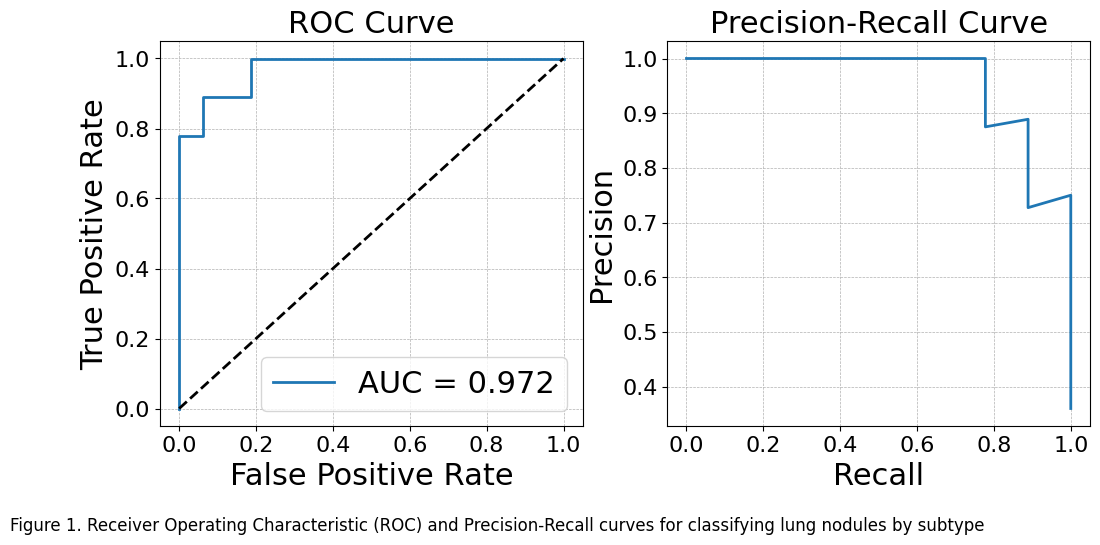

              Metric  Value
            Accuracy 0.9200
           Precision 0.8889
Recall (Sensitivity) 0.8889
         Specificity 0.9375
            F1 Score 0.8889
          Youden’s J 0.8264
   Optimal Threshold 0.6313


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score, 
    f1_score, accuracy_score, precision_recall_curve
)
plt.figure(figsize=(14,6))
plt.rc("font", size=16)

# === Compute ROC and AUC ===
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# === Determine optimal threshold (Youden's J statistic) ===
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

# === Binarize predictions at optimal threshold ===
binary_preds = (all_probs >= optimal_threshold).astype(int)

# === Compute metrics ===
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
specificity = precision_score(all_labels, binary_preds, pos_label=0)
f1 = f1_score(all_labels, binary_preds)
accuracy = accuracy_score(all_labels, binary_preds)
youden_j_value = recall - (1 - specificity)

# === Plot ROC Curve ===
# plt.figure(figsize=(6, 5))

fig = plt.figure(figsize=(12, 5))  # Create a figure manually
caption = """Figure 1. Receiver Operating Characteristic (ROC) and Precision-Recall curves for classifying lung nodules by subtype."""

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlabel("False Positive Rate", fontsize=22)
plt.ylabel("True Positive Rate", fontsize=22)
plt.title("ROC Curve", fontsize=22)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(loc="lower right", fontsize=22)
fig.text(0,-.1, caption, ha='left', fontsize=12)

# === Plot Precision-Recall Curve ===
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_probs)
# plt.figure(figsize=(6, 5))
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, linewidth=2)
plt.xlabel("Recall", fontsize=22)
plt.ylabel("Precision", fontsize=22)
plt.title("Precision-Recall Curve", fontsize=22)
plt.grid(True, linestyle='--', linewidth=0.5)

# plt.tight_layout(rect=[0, 0.1, 1, 1])

plt.savefig("sclc.png", bbox_inches='tight')
plt.show()


# === Display results as a table ===
metrics_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall (Sensitivity)", "Specificity", "F1 Score", "Youden’s J", "Optimal Threshold"],
    "Value": [accuracy, precision, recall, specificity, f1, youden_j_value, optimal_threshold]
})


# Format for publication
metrics_table["Value"] = metrics_table["Value"].apply(lambda x: f"{x:.4f}")
print(metrics_table.to_string(index=False))




In [14]:
from image import NoduleInfoTuple, NRRDNodule
coord_file = "/home/kaplinsp/ct_lung_class/annotations-sclc.csv"

exclude_paths = ["/data/kaplinsp/transformation/A114.nrrd"]
coord_df = pd.read_csv(coord_file, index_col=False)

coord_df = coord_df[(coord_df["label"] == 2) & (~coord_df["path"].isin(exclude_paths))]

transformed = list(
    coord_df.apply(
        lambda row: NoduleInfoTuple(
            row["label"],
            row["path"],
            (row["x"], row["y"], row["z"]),
            row["path"],
            NRRDNodule,
        ),
        axis=1,
    ).to_numpy()
)

transform_dataset = NoduleDataset(transformed, 
            isValSet_bool=True,
            dilate=20,
            resample=[64, 64, 64],
            box_size=[65, 65, 80],
            fixed_size=True
            )

transformed_dl = DataLoader(
            transform_dataset,
            batch_size=16,
            num_workers=4,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
        )

2025-04-30 13:36:48,871 INFO     pid:3101823 datasets:211:__init__ <datasets.NoduleDataset object at 0x7f7e212b3fa0>: 18 validation samples


In [15]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import torch
import numpy as np
from sklearn.metrics import auc, precision_recall_curve, roc_curve

# Ensure models are in eval mode
for net in networks:
    net.eval()

all_labels, all_probs = [], []
val_dl = make_dataloader(path.format(fold_index=0))

def run_model_on_gpu(model, inputs, device_id):
    device = torch.device(f'cuda:{device_id}')
    inputs.pin_memory()
    input_gpu = inputs.to(device, non_blocking=True)
    with torch.no_grad():
        output = model(input_gpu)
        probs = torch.softmax(output, dim=1)[:, 1].cpu()
    return probs

for inputs, labels in transformed_dl:
    futures = []
    with ThreadPoolExecutor(max_workers=4) as executor:
        for i, model in enumerate(networks):
            futures.append(executor.submit(run_model_on_gpu, model, inputs, i % 4))

        # Collect results
        batch_probs = [future.result() for future in futures]

    avg_probs = torch.stack(batch_probs, dim=0).mean(dim=0)

    all_probs.append(avg_probs)
    all_labels.append(labels.cpu())
# Convert to NumPy
all_probs = torch.cat(all_probs).numpy()
all_labels = [1 for _ in range(len(all_probs))]
pred_labels = (all_probs >= optimal_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(all_labels, pred_labels))
print(classification_report(all_labels, pred_labels))


2025-04-30 13:36:50,277 INFO     pid:3101823 datasets:211:__init__ <datasets.NoduleDataset object at 0x7f7e213abeb0>: 25 validation samples


25
[[ 0  0]
 [14  4]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.22      0.36        18

    accuracy                           0.22        18
   macro avg       0.50      0.11      0.18        18
weighted avg       1.00      0.22      0.36        18



/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
